In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train = pd.read_csv('./used_car_train_20200313.csv', sep=' ')
test = pd.read_csv('./used_car_testB_20200421.csv', sep=' ')

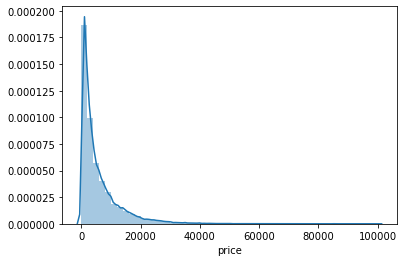

In [3]:
sns.distplot(train['price'])

In [4]:
combine = pd.concat([train, test], axis=0, ignore_index=True)
combine.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [5]:
#将特征分为3部分，日期特征，类别特征，数字特征
date_cols = ['regDate', 'creatDate']
cate_cols = ['name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'regionCode', 'seller', 'offerType']
num_cols = ['power', 'kilometer'] + ['v_{}'.format(i) for i in range(15)]

cols = date_cols + cate_cols + num_cols

In [6]:
#统计出数据的分布情况
temp = pd.DataFrame()
temp['count'] = combine[cols].count()
temp['missing_rate'] = (combine.shape[0] - temp['count'])/combine.shape[0]
temp['unique'] = combine[cols].nunique()
temp['max_value_counts'] = [combine[f].value_counts().values[0] for f in cols]
temp['max_value_counts_prop'] = temp['max_value_counts']/combine.shape[0]
temp['max_value_counts_value'] = [combine[f].value_counts().index[0] for f in cols]
temp

,count,missing_rate,unique,max_value_counts,max_value_counts_prop,max_value_counts_value
regDate,200000,0.000000,3898,235,0.001175,20000008
creatDate,200000,0.000000,106,7820,0.039100,20160403
name,200000,0.000000,128660,376,0.001880,387
model,199999,0.000005,248,15534,0.077670,0
brand,200000,0.000000,40,41953,0.209765,0
bodyType,193990,0.030050,8,55185,0.275925,0
fuelType,188396,0.058020,7,122145,0.610725,0
gearbox,192051,0.039745,2,148754,0.743770,0
notRepairedDamage,200000,0.000000,3,148585,0.742925,0.0
regionCode,200000,0.000000,8010,489,0.002445,419


把日期列处理一下，提取年、月、日、星期等信息。这里有些日期异常的样本，月份出现了0，因此需要开个函数单独处理一下。

In [7]:
from tqdm import tqdm


def date_proc(x):
    m = int(x[4:6])
    if m == 0:
        m = 1
    return x[:4] + '-' + str(m) + '-' + x[6:]


for f in tqdm(date_cols):
    combine[f] = pd.to_datetime(combine[f].astype('str').apply(date_proc))
    combine[f + '_year'] = combine[f].dt.year
    combine[f + '_month'] = combine[f].dt.month
    combine[f + '_day'] = combine[f].dt.day
    combine[f + '_dayofweek'] = combine[f].dt.dayofweek

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.10it/s]


<Figure size 432x288 with 0 Axes>

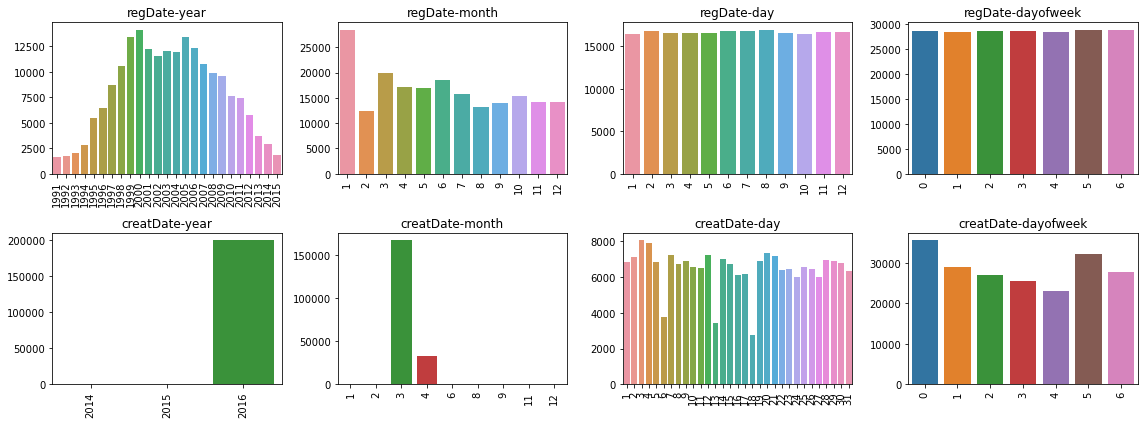

In [8]:
plt.figure()
plt.figure(figsize=(16, 6))
i = 1
for f in date_cols:
    for col in ['year', 'month', 'day', 'dayofweek']:
        plt.subplot(2, 4, i)
        i = i + 1
        v = combine[f + '_' + col].value_counts()
        fig = sns.barplot(x=v.index, y=v.values)
        for item in fig.get_xticklabels():
            item.set_rotation(90)
            plt.title(f + '-' + col)

plt.tight_layout()
plt.show()

In [9]:
cate_cols.remove('seller')
cate_cols.remove('offerType')

In [10]:
combine['used_time'] = (pd.to_datetime(combine['creatDate'], format='%Y%m%d', errors='coerce') - 
                      pd.to_datetime(combine['regDate'], format='%Y%m%d', errors='coerce')).dt.days

In [11]:
#由于date信息已经提取完毕，更新一下其信息，可以去掉原来的regDate
date_cols = ['regDate_year', 'regDate_month', 'regDate_day', 'regDate_dayofweek', 'creatDate_month', 'creatDate_day', 'creatDate_dayofweek']

In [12]:
num_cols.append('used_time')

In [13]:
#从相关系数矩阵可以看出特征的重要性
corr_df = combine[~combine['price'].isnull()][['price'] + num_cols + date_cols].corr().abs()
corr_df['price'].sort_values(ascending=False)

price                  1.000000
v_3                    0.730946
v_12                   0.692823
v_8                    0.685798
v_0                    0.628397
used_time              0.612014
regDate_year           0.611814
kilometer              0.440519
v_11                   0.275320
v_10                   0.246175
power                  0.219834
v_9                    0.206205
v_5                    0.164317
v_4                    0.147085
v_2                    0.085322
v_6                    0.068970
v_1                    0.060914
regDate_month          0.059800
v_7                    0.053024
v_14                   0.035911
v_13                   0.013993
creatDate_month        0.012834
creatDate_dayofweek    0.007489
regDate_dayofweek      0.004601
regDate_day            0.002700
creatDate_day          0.001442
Name: price, dtype: float64

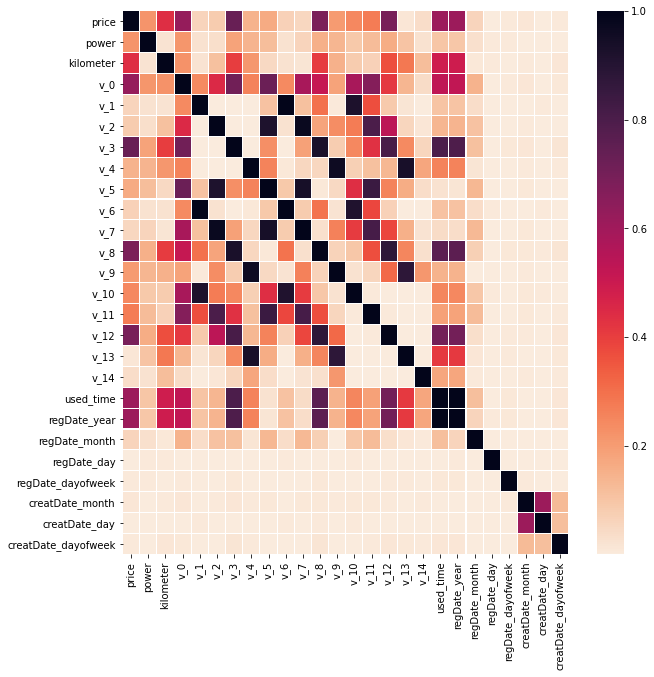

In [14]:
plt.figure(figsize=(10, 10))
sns.heatmap(corr_df, linewidths=0.1, cmap=sns.cm.rocket_r)

<Figure size 432x288 with 0 Axes>

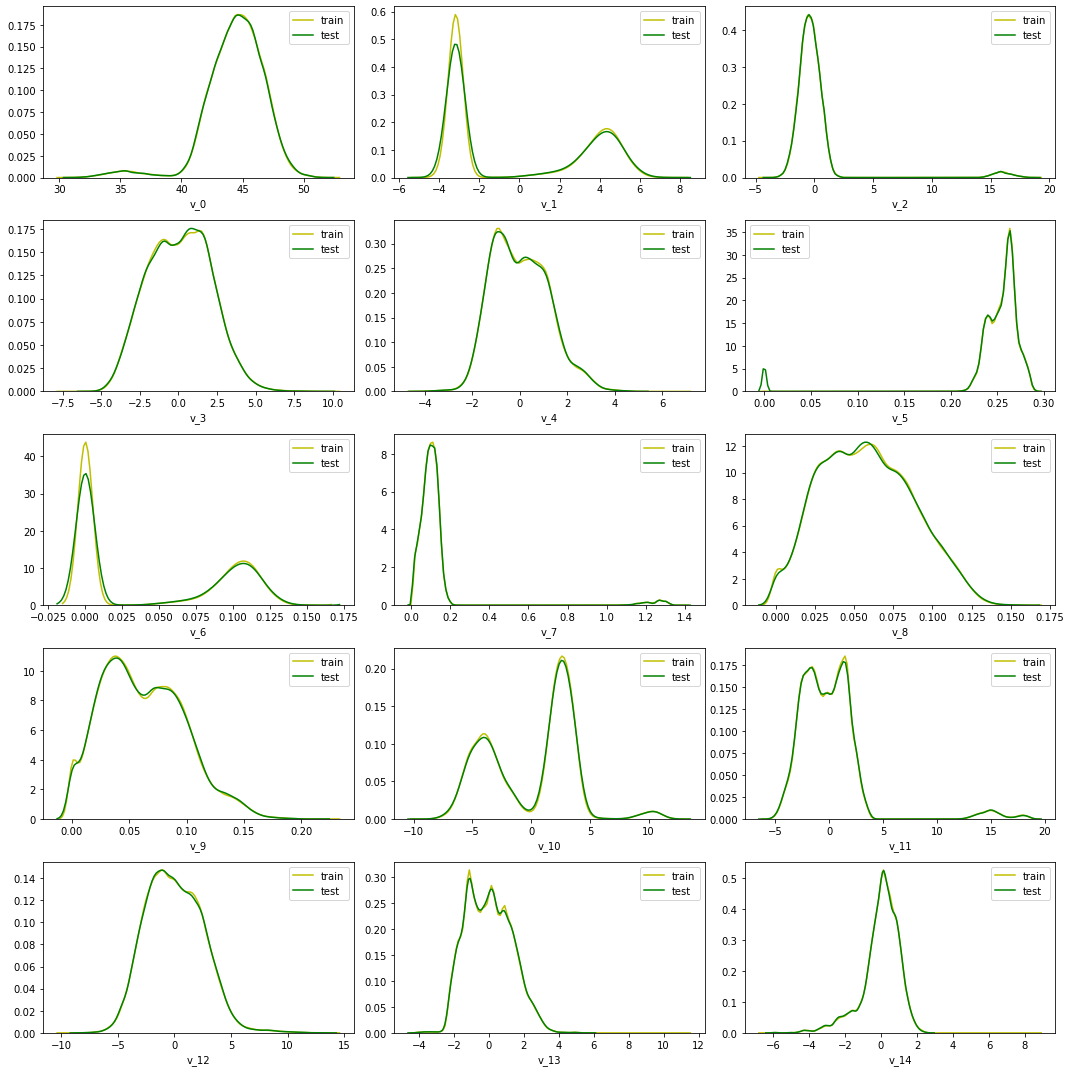

In [15]:
#观察15项匿名特征在训练集和测试集上的分布
plt.figure()
plt.figure(figsize=(15, 15))
i = 1
for f in num_cols[2:17]:
    plt.subplot(5, 3, i)
    i += 1
    sns.distplot(combine[~combine['price'].isnull()][f], label='train', color='y', hist=False)
    sns.distplot(combine[combine['price'].isnull()][f], label='test', color='g', hist=False)
plt.tight_layout()
plt.show()

In [16]:
combine.isnull().sum()

SaleID                     0
name                       0
regDate                    0
model                      1
brand                      0
bodyType                6010
fuelType               11604
gearbox                 7949
power                      0
kilometer                  0
notRepairedDamage          0
regionCode                 0
seller                     0
offerType                  0
creatDate                  0
price                  50000
v_0                        0
v_1                        0
v_2                        0
v_3                        0
v_4                        0
v_5                        0
v_6                        0
v_7                        0
v_8                        0
v_9                        0
v_10                       0
v_11                       0
v_12                       0
v_13                       0
v_14                       0
regDate_year               0
regDate_month              0
regDate_day                0
regDate_dayofw

In [17]:
#构造使用时间特征，好像可以抛弃前面时间特征了；再来看看其他的数值特征
combine['kilometer'].value_counts()         #kilometer已经分桶

15.0    129120
12.5     21035
10.0      8629
9.0       6941
8.0       6103
7.0       5469
6.0       4951
5.0       4254
4.0       3610
3.0       3339
2.0       3122
0.5       2441
1.0        986
Name: kilometer, dtype: int64

In [18]:
combine[num_cols]

,power,kilometer,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,used_time
0,60,12.5,43.357796,3.966344,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762,4385
1,0,15.0,45.305273,5.236112,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522,4757
2,163,12.5,45.978359,4.823792,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963,4382
3,193,15.0,45.687478,4.492574,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,7125
4,68,5.0,44.383511,2.031433,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482,1531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,150,15.0,46.321013,-3.304401,0.073363,-0.622359,-0.778349,0.263668,0.000292,0.141804,0.076393,0.039272,2.072901,-2.531869,1.716978,-1.063437,0.326587,4173
199996,179,4.0,48.086547,-3.318641,0.965881,-2.672160,0.357440,0.255310,0.000991,0.155868,0.108425,0.067841,1.358504,-3.290295,4.269809,0.140524,0.556221,1079
199997,147,12.5,46.145279,-3.305263,-0.015283,-0.288329,-0.687112,0.262933,0.000318,0.141872,0.071968,0.042966,2.165658,-2.417885,1.370612,-1.073133,0.270602,4113
199998,176,15.0,45.507088,-3.197006,-1.141252,-0.434930,-1.845040,0.282106,0.000023,0.067483,0.067526,0.009006,2.030114,-2.939244,0.569078,-1.718245,0.316379,5017


In [19]:
combine[cate_cols].isnull().sum()

name                     0
model                    1
brand                    0
bodyType              6010
fuelType             11604
gearbox               7949
notRepairedDamage        0
regionCode               0
dtype: int64

In [20]:
#用众数填充缺失的model值
combine['model'].fillna(combine['model'].median(), inplace=True)

In [21]:
temp

,count,missing_rate,unique,max_value_counts,max_value_counts_prop,max_value_counts_value
regDate,200000,0.000000,3898,235,0.001175,20000008
creatDate,200000,0.000000,106,7820,0.039100,20160403
name,200000,0.000000,128660,376,0.001880,387
model,199999,0.000005,248,15534,0.077670,0
brand,200000,0.000000,40,41953,0.209765,0
bodyType,193990,0.030050,8,55185,0.275925,0
fuelType,188396,0.058020,7,122145,0.610725,0
gearbox,192051,0.039745,2,148754,0.743770,0
notRepairedDamage,200000,0.000000,3,148585,0.742925,0.0
regionCode,200000,0.000000,8010,489,0.002445,419


类别数量较少可以先不管，几百个那种可以分桶

In [22]:
#以下特征填充全部用众数填充
combine['bodyType'].fillna(combine['bodyType'].median(), inplace=True)
combine['fuelType'].fillna(combine['fuelType'].median(), inplace=True)
combine['gearbox'].fillna(combine['gearbox'].median(), inplace=True)
combine.isnull().sum()

SaleID                     0
name                       0
regDate                    0
model                      0
brand                      0
bodyType                   0
fuelType                   0
gearbox                    0
power                      0
kilometer                  0
notRepairedDamage          0
regionCode                 0
seller                     0
offerType                  0
creatDate                  0
price                  50000
v_0                        0
v_1                        0
v_2                        0
v_3                        0
v_4                        0
v_5                        0
v_6                        0
v_7                        0
v_8                        0
v_9                        0
v_10                       0
v_11                       0
v_12                       0
v_13                       0
v_14                       0
regDate_year               0
regDate_month              0
regDate_day                0
regDate_dayofw

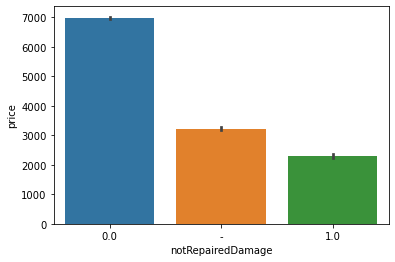

In [23]:
sns.barplot(x='notRepairedDamage', y='price', data=combine) 

In [24]:
combine['notRepairedDamage'] = combine['notRepairedDamage'].astype('str').apply(lambda x: x if x != '-' else None).astype('float16')
combine['notRepairedDamage'].fillna(combine['notRepairedDamage'].median(), inplace=True)

In [25]:
#去掉时间相关的特征
combine.drop(columns=date_cols, inplace=True)
combine.drop(columns=['creatDate_year'], inplace=True)
combine.drop(columns=['creatDate', 'regDate'], inplace=True)

In [26]:
combine.head()

,SaleID,name,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,...,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,used_time
0,0,736,30.0,6,1.0,0.0,0.0,60,12.5,0.0,...,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762,4385
1,1,2262,40.0,1,2.0,0.0,0.0,0,15.0,0.0,...,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522,4757
2,2,14874,115.0,15,1.0,0.0,0.0,163,12.5,0.0,...,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963,4382
3,3,71865,109.0,10,0.0,0.0,1.0,193,15.0,0.0,...,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,7125
4,4,111080,110.0,5,1.0,0.0,0.0,68,5.0,0.0,...,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482,1531


In [27]:
combine['power'].value_counts()

0        17219
75       12784
150       8717
60        8521
140       7879
         ...  
1151         1
575          1
703          1
14009        1
319          1
Name: power, Length: 616, dtype: int64

In [28]:
#对可分类的连续特征进行分桶，kilometer已经分桶
combine['power'] = combine['power'].map(lambda x: 600 if x>600 else x)
#power分桶,根据nunique数量
combine['power_bin'] = pd.cut(combine['power'], 23, labels=False)              

In [29]:
#model分桶，根据nunique
combine['model_bin'] = pd.cut(combine['model'], 24, labels=False)

In [30]:
#去掉offerType和seller
combine.drop(columns=['offerType', 'seller'], inplace=True)

In [31]:
#去掉offerType和seller
combine.drop(columns=['power', 'model'], inplace=True)

In [32]:
combine['regionCode'].value_counts()

419     489
764     356
176     184
462     176
125     174
       ... 
7448      1
7670      1
8097      1
7662      1
4343      1
Name: regionCode, Length: 8010, dtype: int64

In [33]:
combine.head()

,SaleID,name,brand,bodyType,fuelType,gearbox,kilometer,notRepairedDamage,regionCode,price,...,v_8,v_9,v_10,v_11,v_12,v_13,v_14,used_time,power_bin,model_bin
0,0,736,6,1.0,0.0,0.0,12.5,0.0,1046,1850.0,...,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762,4385,2,2
1,1,2262,1,2.0,0.0,0.0,15.0,0.0,4366,3600.0,...,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522,4757,0,3
2,2,14874,15,1.0,0.0,0.0,12.5,0.0,2806,6222.0,...,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963,4382,6,11
3,3,71865,10,0.0,0.0,1.0,15.0,0.0,434,2400.0,...,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,7125,7,10
4,4,111080,5,1.0,0.0,0.0,5.0,0.0,6977,5200.0,...,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482,1531,2,10


In [34]:
#one_hot编码
combine=pd.get_dummies(columns=['brand','bodyType','fuelType','gearbox','kilometer','power_bin','model_bin'],data=combine)

In [35]:
#训练集
train2 = combine[~combine['price'].isnull()]
x_train = train2.drop(columns=['price'])
y_train = train2['price'] 
#测试集
x_test = combine[combine['price'].isnull()].drop(columns=['price'])

In [36]:
from sklearn.preprocessing import StandardScaler
#训练数据标准化
scaler=StandardScaler()
scaler.fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)

In [37]:
from sklearn.model_selection import train_test_split
#切分数据集
x_train,x_val, y_train, y_val = train_test_split(x_train, y_train,test_size = 0.2, random_state=28)

from sklearn.model_selection import KFold
from lightgbm.sklearn import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time


reg = LGBMRegressor(n_estimators=2000, 
         num_leaves =127,
         max_depth = -1,
         lambda_l2 = 2,  # 防止过拟合
         min_data_in_leaf = 20,  # 防止过拟合，好像都不用怎么调
         learning_rate= 0.1,
         min_child_samples = 12,
         feature_fraction = 0.8,
         bagging_freq = 1,
         bagging_fraction = 0.8,
         bagging_seed = 11,
         metric = 'mae',)

reg.fit(
        x_train,y_train,
        eval_set=[(x_val, y_val)],
        eval_metric='mae',
        early_stopping_rounds=100,
        verbose=200
    )

Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 582.395
[400]	valid_0's l1: 561.913
[600]	valid_0's l1: 552.212
[800]	valid_0's l1: 547.577
[1000]	valid_0's l1: 544.898
[1200]	valid_0's l1: 542.646
[1400]	valid_0's l1: 541.419
[1600]	valid_0's l1: 540.118
[1800]	valid_0's l1: 539.285
[2000]	valid_0's l1: 538.668
Did not meet early stopping. Best iteration is:
[1986]	valid_0's l1: 538.66


LGBMRegressor(bagging_fraction=0.8, bagging_freq=1, bagging_seed=11,
              feature_fraction=0.8, lambda_l2=2, metric='mae',
              min_child_samples=1, min_data_in_leaf=20, n_estimators=2000,
              num_leaves=127)

In [38]:
#比较训练集和测试集效果
mean_absolute_error(y_train,reg.predict(x_train))

104.89165209164236

In [39]:
mean_absolute_error(y_val,reg.predict(x_val))

538.6598330416579